In [40]:
import numpy as np
import matplotlib.pyplot as plt
import bilby
import pandas as pd
from gwpy.timeseries import TimeSeries
import scipy

In [71]:
duration = 4
sampling_frequency = 2048
t0_gps = 1126259460.4
n_samples = duration*sampling_frequency
time = np.linspace(0, duration, n_samples)

In [ ]:
def interpolate(current_frequencies, current_values, target_frequencies):
    f = scipy.interpolate.interp1d(current_frequencies, current_values)
    return f(target_frequencies)

def whitening(strain, psd):
    return strain / np.sqrt(psd)

def match_filter(strain, waveform):
    norm = np.sqrt(np.sum(waveform ** 2))
    waveform_r = waveform[::-1]
    snr = np.convolve(strain, waveform_r, mode='same') / norm
    return snr

def to_time_domain(freq, freq_data, n_samples):
    full_spectrum = np.zeros(n_samples, dtype=complex)
    n_freqs = len(freq)
    full_spectrum[:n_freqs] = freq_data
    full_spectrum[n_freqs:] = np.conj(freq_data[-2:0:-1])  # Hermitian symmetry
    return np.fft.ifft(full_spectrum).real

def get_tc(snr, time):
    peak_idx = np.argmax(np.abs(snr))
    peak_time = time[peak_idx]
    peak_val = np.abs(snr[peak_idx])
    half_max = peak_val / 2
    indices = np.where(np.abs(snr) > half_max)[0]
    fwhm = time[indices[-1]] - time[indices[0]]
    return peak_time, fwhm

In [43]:
waveform = np.loadtxt('data/waveform.txt')
h1_strain = np.loadtxt('data/H1_strain.txt')
l1_strain = np.loadtxt('data/L1_strain.txt')
h1_psd = np.loadtxt('data/H1_psd.txt')
l1_psd = np.loadtxt('data/L1_psd.txt')

In [77]:
waveform = pd.DataFrame(data=waveform, columns=['Hz', 'Re(h+)', 'Im(h+)', 'Re(hx)', 'Im(hx)'])
h1_strain = pd.DataFrame(data=h1_strain, columns=['Hz', 'Re(h)', 'Im(h)'])
l1_strain = pd.DataFrame(data=l1_strain, columns=['Hz', 'Re(h)', 'Im(h)'])
h1_psd = pd.DataFrame(data=h1_psd, columns=['Hz', 'PSD'])
l1_psd = pd.DataFrame(data=l1_psd, columns=['Hz', 'PSD'])

waveform['h+'] = waveform['Re(h+)'] + 1j*waveform['Im(h+)']
waveform['hx'] = waveform['Re(hx)'] + 1j*waveform['Im(hx)']
waveform['h'] = waveform['h+'] + waveform['hx']

h1_strain['h'] = h1_strain['Re(h)'] + 1j*h1_strain['Im(h)']
l1_strain['h'] = l1_strain['Re(h)'] + 1j*l1_strain['Im(h)']

h1_strain['white'] = whitening(h1_strain['h'], h1_psd['PSD'])
l1_strain['white'] = whitening(l1_strain['h'], l1_psd['PSD'])
waveform['white_h1'] = whitening(waveform['h'], h1_psd['PSD'])
waveform['white_l1'] = whitening(waveform['h'], l1_psd['PSD'])

h1_td = to_time_domain(h1_strain['Hz'], h1_strain['white'],n_samples)
l1_td = to_time_domain(l1_strain['Hz'], l1_strain['white'],n_samples)
waveform_h1_td = to_time_domain(waveform['Hz'], waveform['white_h1'],n_samples)
waveform_l1_td = to_time_domain(waveform['Hz'], waveform['white_l1'],n_samples)

snr_H1 = match_filter(h1_td, waveform_h1_td)
snr_L1 = match_filter(l1_td, waveform_l1_td)
tc_H1, fwhm_H1 = get_tc(snr_H1, time)
tc_L1, fwhm_L1 = get_tc(snr_L1, time)

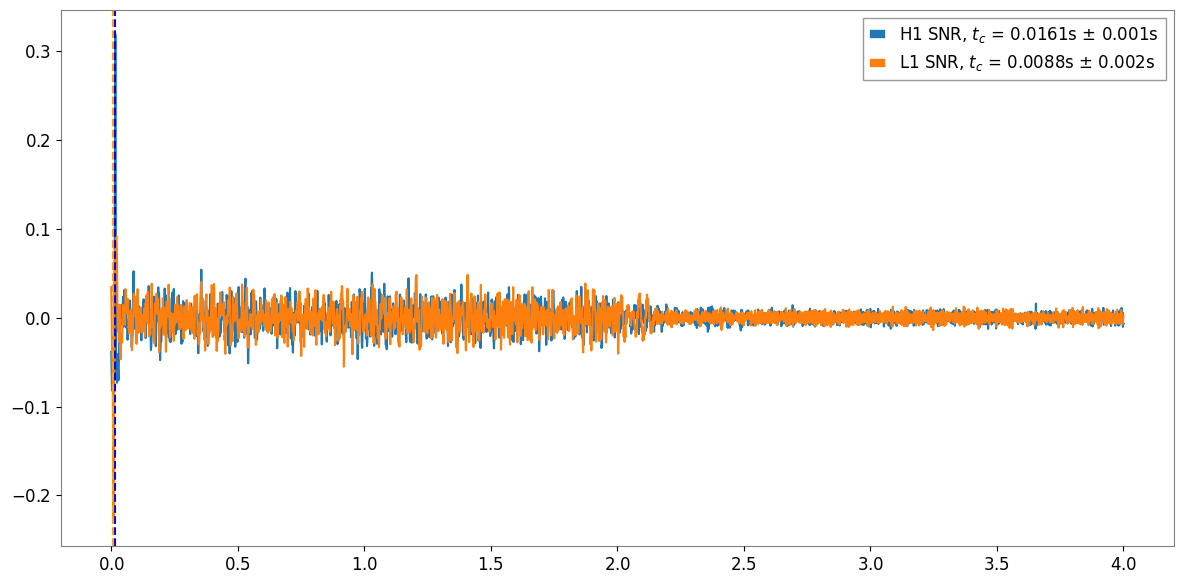

In [87]:
plt.figure(figsize=(12,6))
plt.plot(time, snr_H1, label=fr'H1 SNR, $t_c$ = {tc_H1:.4f}s ± {fwhm_H1/2:.3f}s')
plt.plot(time, snr_L1, label=fr'L1 SNR, $t_c$ = {tc_L1:.4f}s ± {fwhm_L1/2:.3f}s')
plt.axvline(tc_H1, color='blue', linestyle='--')
plt.axvline(tc_L1, color='orange', linestyle='--')
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

In [56]:
IFOH = bilby.gw.detector.InterferometerList(['H1'])[0]
IFOH.power_spectral_density = h1_psd['PSD']
IFOH.frequency_array = h1_psd['Hz']

IFOL = bilby.gw.detector.InterferometerList(['L1'])[0]
IFOL.power_spectral_density = l1_psd['PSD']
IFOL.frequency_array = l1_psd['Hz']